# French Motor Insurance Coding Challenge

Welcome to the **first part** of the French Motor Insurance Coding Challenge. In this notebook, I will focus on **exploring the dataset** and preparing the features necessary for predicting insurance claim amounts.


**Objectives:**

1.	Explorative Datenanalyse (EDA): 
- *Goal*:  to familiarize myself with the data, identifying any potential issues such as missing values or outliers, and uncovering key statistical patterns. 
2.	Feature Engineering: 
-  *Goal*: After investigating the data, propose and create additional variables.


**Scope of This Notebook:**

- **No Modeling:** 
    - It’s important to note that this notebook does not include the actual modeling process. Instead, my focus here is on preparing the data to ensure that it is in optimal shape when I start building predictive models.\
- **Next Steps:** 
    - In the following notebook, I will proceed with splitting the dataset into training and testing sets, scaling the features as necessary, and building and evaluating predictive models based on the work done here.

**Data Source**: 

The data for the notebook can be found here:
* Feature Data: [freMTPL2freq](https://www.openml.org/d/41214)
* Target Data: [freMTPL2sev](https://www.openml.org/d/41214)



---
## Importing Libraries

In [483]:
import os
import sys

from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

import sklearn as sk
import scipy as sp

import scipy.stats as stats
from sklearn.datasets import fetch_openml



---
## Loading Data

The dataset for this analysis is hosted on the [OpenML](https://www.openml.org/) platform, which provides a wide range of datasets for machine learning tasks. 

I will use the `fetch_openml` function to directly access and load the data into this notebook. This method allows for easy and efficient retrieval of datasets, ensuring that the latest version is always used.

In [484]:
# Abrufen der Claims-Daten von OpenML
print("Abrufen des 'freMTPL2sev'-Datensatzes von OpenML...")
try:
    df_claims = fetch_openml(name="freMTPL2sev", as_frame=True).data
    print("'freMTPL2sev'-Datensatz erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden des 'freMTPL2sev'-Datensatzes. Fehler: {e}")

# Abrufen der Features-Daten von OpenML
print("Abrufen des 'freMTPL2freq'-Datensatzes von OpenML...")
try:
    df_features = fetch_openml(name="freMTPL2freq", as_frame=True).data
    print("'freMTPL2freq'-Datensatz erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden des 'freMTPL2freq'-Datensatzes. Fehler: {e}")

# Anzeigen der ersten Zeilen beider DataFrames
print("\nVorschau des 'freMTPL2sev' (Claims-Daten):")
display(df_claims.head()) 
print(f'The shape of the dataframe: {df_claims.shape}')

print("\nVorschau des 'freMTPL2freq' (Features-Daten):")
display(df_features.head())
print(f'The shape of the dataframe: {df_features.shape}')
  

Abrufen des 'freMTPL2sev'-Datensatzes von OpenML...
'freMTPL2sev'-Datensatz erfolgreich geladen.
Abrufen des 'freMTPL2freq'-Datensatzes von OpenML...
'freMTPL2freq'-Datensatz erfolgreich geladen.

Vorschau des 'freMTPL2sev' (Claims-Daten):


,IDpol,ClaimAmount
0,1552,995.20
1,1010996,1128.12
2,4024277,1851.11
3,4007252,1204.00
4,4046424,1204.00


The shape of the dataframe: (26639, 2)

Vorschau des 'freMTPL2freq' (Features-Daten):


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,'Regular',1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,'Regular',1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,'Diesel',54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,'Diesel',76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,'Diesel',76,R72


The shape of the dataframe: (678013, 12)


In [485]:
# Überprüfen, ob jede IDpol nur einen Datensatz hat, und anzeigen, bei welchen IDs es mehr als einen Anspruch gibt
id_counts = df_claims['IDpol'].value_counts()

# Anzeigen der IDs mit den meisten Ansprüchen (Top 10)
print("Top 10 IDs mit den meisten Ansprüchen:")
print(id_counts.head(10))

# Aggregieren der ClaimAmount nach IDpol, um sicherzustellen, dass die Summe der aggregierten Daten korrekt ist
df_claims_agg = df_claims.groupby('IDpol').agg({'ClaimAmount': 'sum'}).reset_index()

# Überprüfen, ob die aggregierte Summe der Ansprüche der ursprünglichen Summe entspricht
is_sum_equal = df_claims_agg['ClaimAmount'].sum() == df_claims['ClaimAmount'].sum()
print("Stimmen die aggregierten Summen mit den ursprünglichen Summen überein?", is_sum_equal)

Top 10 IDs mit den meisten Ansprüchen:
IDpol
2262511    66
2282134    36
2227533    25
2220367    24
2277846    23
2286775    21
2241683    16
3253234    11
3254353    11
2248174     9
Name: count, dtype: int64
Stimmen die aggregierten Summen mit den ursprünglichen Summen überein? True


In predictive modeling, it’s common to have one DataFrame containing the features (independent variables) and another DataFrame containing the target variable (dependent variable). To build a model, you need to combine these two DataFrames into a single DataFrame where each row represents a complete data point with both features and the corresponding target.

In [486]:
df_merged = pd.merge(df_features, df_claims, on="IDpol")

df_merged.head(3)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,139.0,1,0.75,F,7,1,61,50,B12,'Regular',27000,R11,303.00
1,190.0,1,0.14,B,12,5,50,60,B12,'Diesel',56,R25,1981.84
2,414.0,1,0.14,E,4,0,36,85,B12,'Regular',4792,R11,1456.55


## Explorative Datenanalyse und Datenbereinigung

In diesem Schritt werde ich die Daten verarbeiten, um ihre Qualität und Einsatzbereitschaft für die Analyse sicherzustellen. Ich werde mich darauf konzentrieren, Ausreißer, fehlende Werte und falsche Eingaben (wie Tippfehler oder andere Anomalien) zu identifizieren und zu beheben. Zunächst werde ich die Datentypen der einzelnen Variablen untersuchen, um die Struktur des Datensatzes zu verstehen und festzustellen, ob Konvertierungen oder Korrekturen erforderlich sind.

#### Checking data types and creating target variable

I begin by examining the data types of the DataFrame. Notably, the IDpol variable is currently stored as `float64`, but it would be more appropriate as `int32` to optimize memory usage and ensure precision.

Additionally, some variables like VehGas and VehPower are incorrectly typed and should be converted to categorical variables to reflect their true nature.

Furthermore, I will construct a new target feature by combining Density and ClaimAmount, which may provide valuable insights for the modeling process.

In [487]:
df_merged.dtypes

IDpol           float64
ClaimNb           int64
Exposure        float64
Area           category
VehPower          int64
VehAge            int64
DrivAge           int64
BonusMalus        int64
VehBrand       category
VehGas           object
Density           int64
Region         category
ClaimAmount     float64
dtype: object

In [488]:
#create target variable which is claim amount/exposure
df_merged['Target'] = df_merged['ClaimAmount'] / df_merged['Exposure']

#### Checking for missing values and duplicates

The next step is to check for missing values and duplicates. It’s essential to ensure that the dataset is complete and free of any duplicated variables. If any issues are found, they should be addressed promptly to maintain data integrity.

In [489]:
# Check for duplicated rows in the merged dataframe
num_duplicates = df_merged.duplicated().sum()
print(f'Number of duplicated rows in the dataframe: {num_duplicates}')

# Drop duplicated rows if any
if num_duplicates > 0:
    df_merged = df_merged.drop_duplicates()
    print(f'Duplicated rows have been dropped. New shape of the dataframe: {df_merged.shape}')
else:
    print('No duplicated rows found.')

# Check for missing values in the dataframe
total_missing_values = df_merged.isnull().sum().sum()
print(f'Total number of missing values in the dataframe: {total_missing_values}')

Number of duplicated rows in the dataframe: 235
Duplicated rows have been dropped. New shape of the dataframe: (26209, 14)
Total number of missing values in the dataframe: 0


### First View at the Feature Data

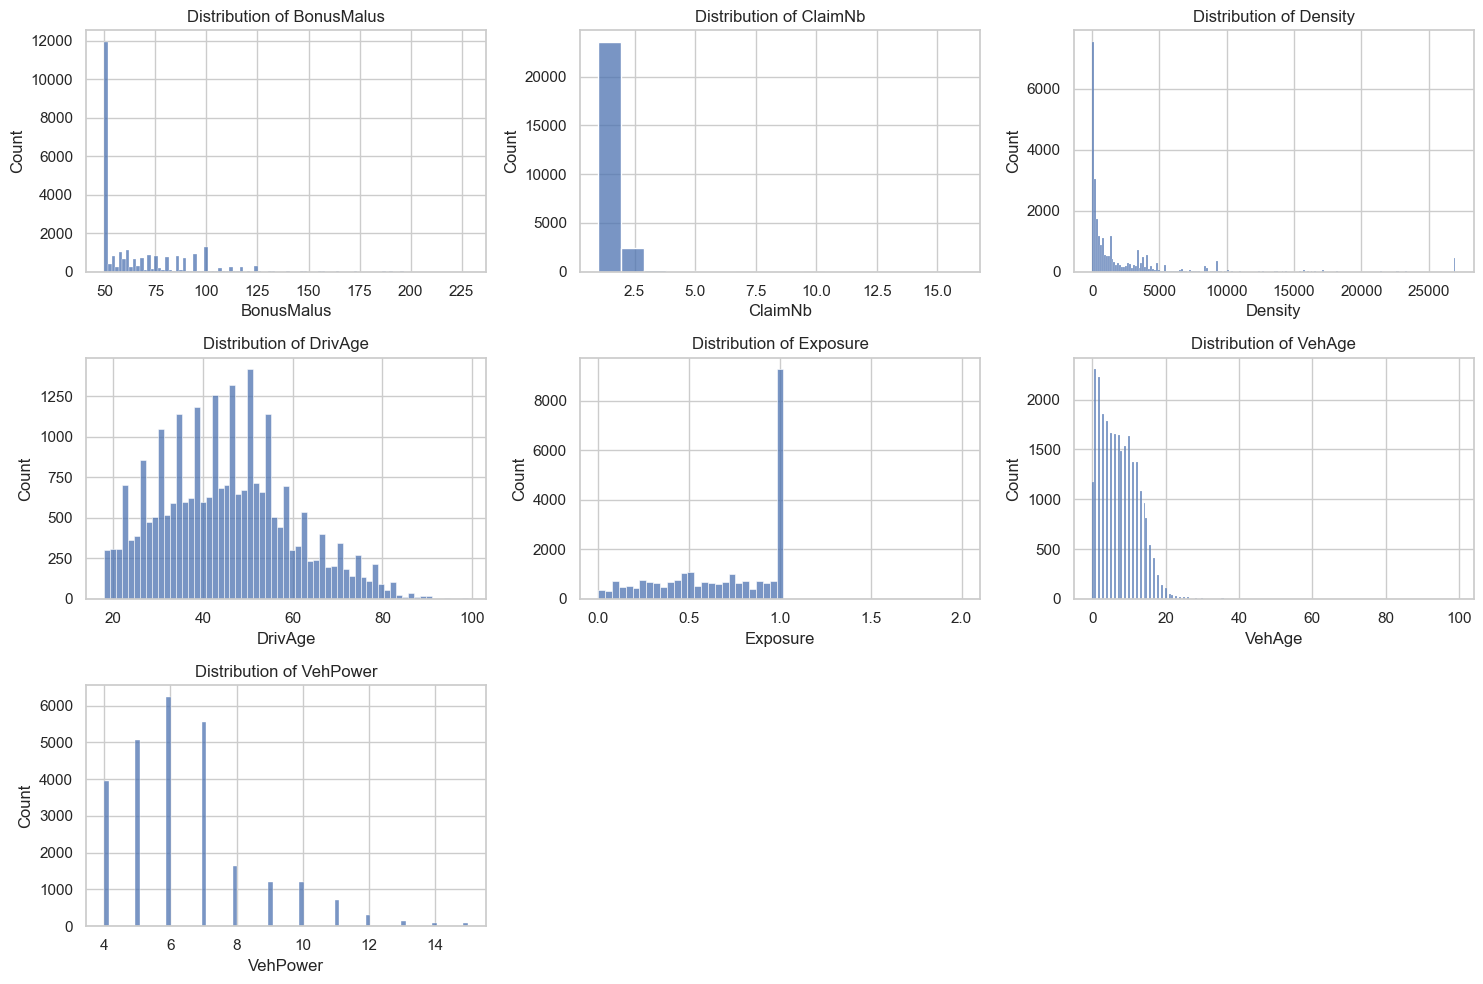

In [490]:
#Plot histograms for numerical features to understand their distribution (e.g., skewness, kurtosis)., exclude claim amount
numerical_features = df_merged.select_dtypes(include=[np.number]).columns.difference(['ClaimAmount','IDpol', 'Target'])
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_merged[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

**First Analyse:**
1.	Skewed distributions:
- ClaimNb shows a significant right skew, with the majority of policies having few claims. 
- Density and BonusMalus also show a skewed distribution, suggesting that most policyholders live in less densely populated areas and maintain low or average bonus-malus levels.
2.	VehAge and DrivAge:
- VehAge (vehicle age) shows a concentration of vehicles under 10 years old, with a steep decline in older vehicles, suggesting that newer cars are more common in the dataset.
- DrivAge (driver age) shows an almost normal distribution with a peak around the age of 50, indicating that middle-aged drivers are the most common policyholders.
3.	VehPower:
- The distribution of VehPower is skewed towards lower power vehicles, with a sharp drop off after a power level of 6, indicating that most policyholders own vehicles of moderate power.
4.	Exposure:
- Exposure is mostly clustered around 1, indicating that most policies cover a full year's exposure, which is expected for annual policies.



**Recommendations:**

- Log transformation: Given the skewness of the Density, applying a log transformation during modelling could improve performance.
- Feature engineering: Since exposure is used in the target variable, we can create bins for exposure or exclude it from modelling altogether to avoid the model relying too heavily on this data. In addition, we can create features that might capture the non-linear relationships suggested by the distributions, such as interaction terms between DrivAge and VehAge. VehAge can also be binned for the modeling purposes.

### Checking categorical values
I begin by examining the categorical variables to identify any potential problems, such as mistyped values or opportunities for optimisation. This step ensures that all categorical data is correctly classified and formatted, and helps to determine whether any adjustments or reclassifications are required.

In [491]:
cat_columns = df_merged.select_dtypes(include=['object', 'category']).columns
for col in cat_columns:
    #print unique values for each column and sort lists alphabetically
    print(f'Column {col} has {len(df_merged[col].unique().tolist())} unique values: {df_merged[col].unique().tolist()}')

Column Area has 6 unique values: ['F', 'B', 'E', 'A', 'D', 'C']
Column VehBrand has 11 unique values: ['B12', 'B1', 'B4', 'B3', 'B2', 'B5', 'B6', 'B14', 'B10', 'B11', 'B13']
Column VehGas has 2 unique values: ["'Regular'", "'Diesel'"]
Column Region has 22 unique values: ['R11', 'R25', 'R73', 'R93', 'R31', 'R21', 'R91', 'R22', 'R72', 'R52', 'R26', 'R82', 'R41', 'R94', 'R24', 'R83', 'R54', 'R23', 'R53', 'R74', 'R42', 'R43']


##### Area

In [492]:
df_merged['Area'].value_counts()

Area
C    7028
D    6403
E    6062
A    3336
B    2615
F     765
Name: count, dtype: int64

Insights:
- The 'Area' variable has a total of six unique categories labeled A through F.
- There is a noticeable imbalance, with 'C', 'D', and 'E' being much more frequent than 'A', 'B', and especially 'F'.
- This imbalance might have implications for modeling, particularly if 'Area' is an important predictor.

Using ANOVA, I can assess whether there are significant differences in the mean target variable across the different Area categories. The high p-value suggests that these differences are not statistically significant, indicating that the categories could potentially be merged. However, when considering a merge between Category B and Category F (the two smallest categories), it’s important to note that they have markedly different mean values, which may warrant keeping them separate.

ANOVA p-value: 0.5657771868071727


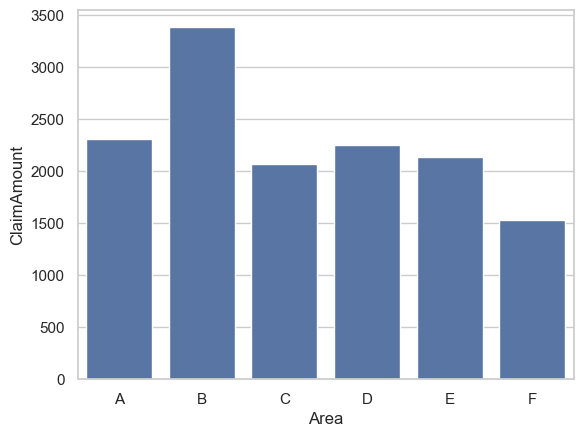

In [493]:
sns.barplot(df_merged.groupby('Area', observed=True)['ClaimAmount'].mean().sort_values())

# Check if Area F is significantly different

f_values, p_values = stats.f_oneway(
    *[group['Target'].values for name, group in df_merged.groupby('Area', observed=True)]
)


print("ANOVA p-value:", p_values)

#### VehBrand

The dataframe contains 14 different car brands, each with varying levels of representation. Brand B1 is the most popular, appearing 6,825 times, while B14 is the least popular among customers. Brands B10, B11, B13, and B14 are notably underrepresented, and this imbalance needs to be addressed.

In [494]:
df_merged['VehBrand'].value_counts()

VehBrand
B1     6825
B2     6736
B12    4172
B3     2410
B5     1648
B6     1240
B4     1095
B10     757
B11     661
B13     535
B14     130
Name: count, dtype: int64

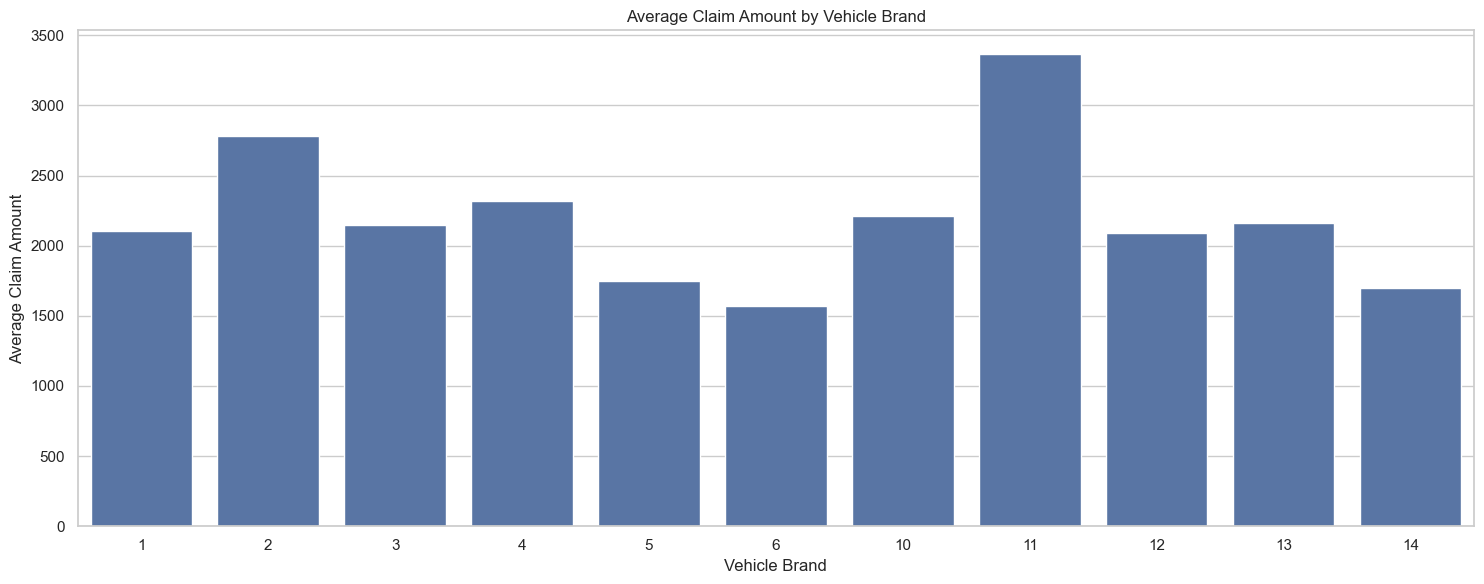

In [495]:
#create a barplot to show the average claim amount for each vehicle brand
#remove b from the name of the vehicle brands
df_merged['VehBrand'] = df_merged['VehBrand'].apply(lambda x: re.sub(r'\bB', '', x))

#convert to integer
df_merged['VehBrand'] = df_merged['VehBrand'].astype(int)

brand_claims = df_merged.groupby('VehBrand')['ClaimAmount'].mean().reset_index()


# Sort the DataFrame
brand_claims_sorted = brand_claims.sort_values(by='VehBrand')

# Create the bar plot
plt.figure(figsize=(15, 6))
sns.barplot(x='VehBrand', y='ClaimAmount', data=brand_claims_sorted)
plt.title('Average Claim Amount by Vehicle Brand')
plt.xlabel('Vehicle Brand')
plt.ylabel('Average Claim Amount')
plt.xticks(rotation=0)  # No need for rotation if numbers are small
plt.tight_layout()
plt.show()

Some brands, such as B10, B11, B13, and B14, are underrepresented in the dataframe, yet they exhibit significant average claim amounts. To address this issue, several strategies can be considered:

**Feature Engineering Approaches:**
1. **Frequency Binning:** 
   - Create bins to categorize brands into High Frequency, Medium Frequency, and Low Frequency groups based on their occurrence.
   
2. **Grouping Rare Brands:** 
   - Combine B10, B11, B13, and B14 into an "Others" category to reduce sparsity and simplify the analysis.

**Modeling Approaches:**
1. **Resampling Techniques:** 
   - Apply resampling methods, such as oversampling the underrepresented brands or undersampling the overrepresented ones, to balance the data.

2. **Algorithm Selection:** 
   - Retain all categories as they are and experiment with algorithms specifically designed to handle imbalanced data, such as decision trees, random forests, or gradient boosting.

Each of these approaches can help ensure that the underrepresented brands are adequately considered in the analysis while maintaining the integrity of the model.

In [496]:
def create_brand_frequency_bins(df, column='VehBrand', n_bins=3):
    # Count the frequency of each brand
    brand_counts = df[column].value_counts()
    
    # Create bins based on frequency
    bins = pd.qcut(brand_counts, q=n_bins, labels=['Low', 'Medium', 'High'])
    
    # Create a mapping dictionary
    brand_frequency_map = dict(zip(brand_counts.index, bins))
    
    # Create new feature
    df[f'{column}_Frequency'] = df[column].map(brand_frequency_map)
    
    return df

# Apply the function to your dataframe
df_merged = create_brand_frequency_bins(df_merged, column='VehBrand', n_bins=3)

#keep categories B10-B14 as 'Other'
df_merged['VehBrand_Other'] = df_merged['VehBrand'].apply(lambda x: 'Other' if x in ['10', '11', '13', '14'] else x)

#convert back to categorical both VehBrand and VehBrand_Frequency
df_merged['VehBrand_Other'] = df_merged['VehBrand_Other'].astype('category')
df_merged['VehBrand'] = df_merged['VehBrand'].astype('category')
df_merged['VehBrand_Frequency'] = df_merged['VehBrand_Frequency'].astype('category')


#### VehGas

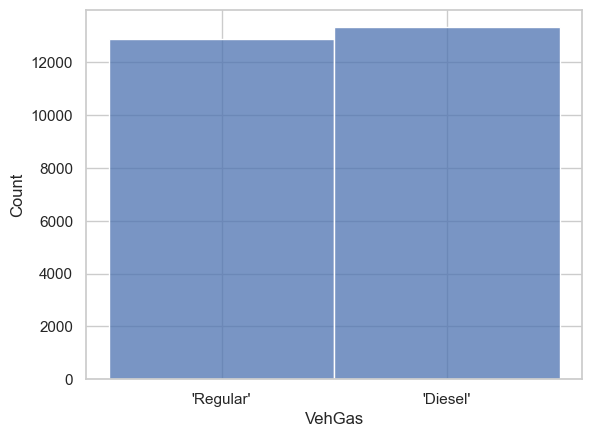

In [382]:
sns.histplot(df_merged['VehGas']);

In [383]:
df_merged['VehGas_binary'] = df_merged['VehGas'].apply(lambda x: 1 if x == "'Diesel'" else 0)
df_merged['VehGas_binary'] = df_merged['VehGas_binary'].astype('category')
df_merged['VehGas'] = df_merged['VehGas'].astype('category')

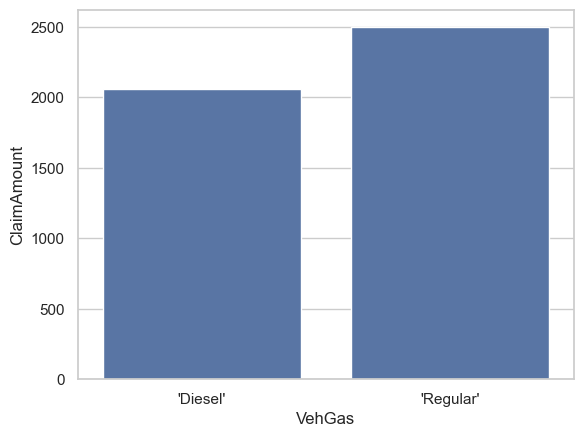

In [384]:
#plot claim amount for each fuel type and plot amount of the claims (claimnb) for each fuel type
sns.barplot(df_merged.groupby('VehGas', observed=True)['ClaimAmount'].mean().sort_values());


#### Region

In [385]:
#analyse region 
df_merged['Region'].value_counts()

Region
R24    6421
R82    4200
R93    2960
R11    2572
R53    1848
R52    1553
R91    1054
R72    1047
R31     932
R54     796
R41     464
R25     448
R73     368
R26     343
R22     314
R23     219
R74     194
R83     140
R94     132
R42      90
R21      77
R43      37
Name: count, dtype: int64

Some regions have a lot of claims, some have just a small amount of them.
We can proceed as for the vehicle brand.

<Figure size 1500x600 with 0 Axes>

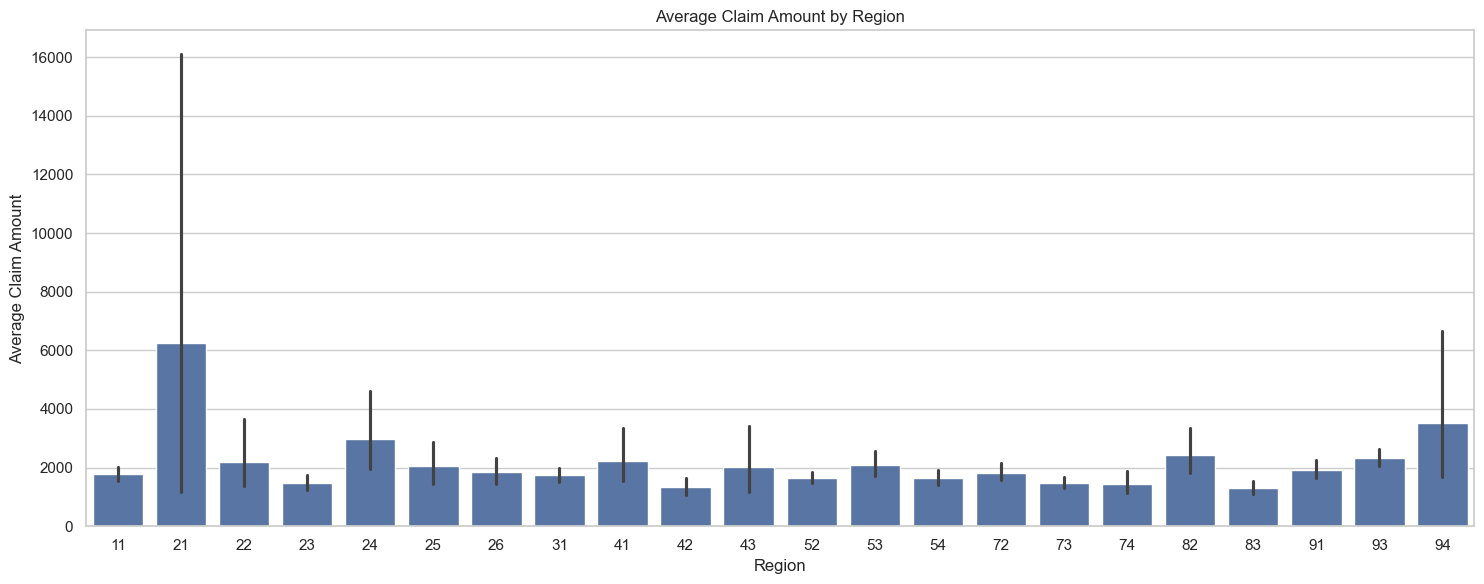

In [386]:
#check claim amount for the regions
plt.figure(figsize=(15, 6))

#convert to str
df_merged['Region'] = df_merged['Region'].astype(str)
#remove R from the brand name
df_merged['Region'] = df_merged['Region'].apply(lambda x: re.sub(r'\bR', '', x))

#convert to integer
df_merged['Region'] = df_merged['Region'].astype(int)
# Create the bar plot

plt.figure(figsize=(15, 6))
sns.barplot(x='Region', y='ClaimAmount', data=df_merged)
plt.title('Average Claim Amount by Region')
plt.xlabel('Region')
plt.ylabel('Average Claim Amount')
plt.xticks(rotation=0)  # No need for rotation if numbers are small
plt.tight_layout()
plt.show()

The situation with Regions is similar to the Vehicle Brand situation. Area 21 being underrepresented still has very high average claim amount, however what we can do is to group regions in the frequency bin and generate descriptive statistics column for each bin. We cannot use claim amount to prevent data leakage. And then we drop Region.

In [387]:
region_stats = df_merged.groupby('Region').agg({
    'Exposure': 'sum',
    'VehPower': 'mean',
    'DrivAge': 'mean',
    'BonusMalus': 'mean'
}).reset_index()

df_merged = df_merged.merge(region_stats, on='Region', how='left', suffixes=('', '_Region_Avg'))

#convert region to categorical
df_merged['Region'] = df_merged['Region'].astype('category')


Text(0.5, 1.0, 'Correlation Matrix')

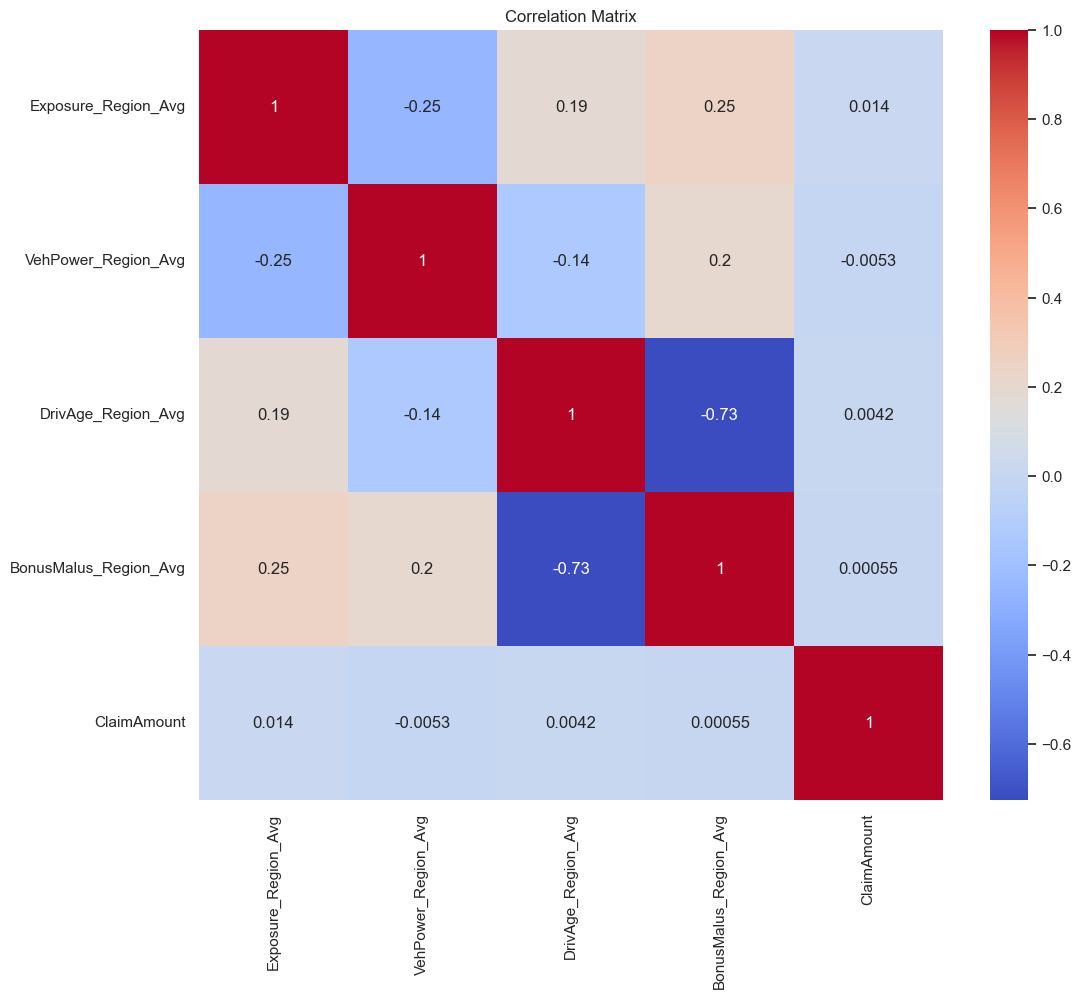

In [388]:
#get all columns that end with _Region_Avg and ClaimAmount
columns_to_keep = [col for col in df_merged.columns if col.endswith('_Region_Avg')] + ['ClaimAmount']
#show correlation matrix
correlation_matrix = df_merged[columns_to_keep].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
    

Based on this correlation matrix, we can draw several conclusions:

Weak correlations with ClaimAmount:
All the region-averaged features (Exposure_Region_Avg, VehPower_Region_Avg, DrivAge_Region_Avg, BonusMalus_Region_Avg) show very weak correlations with ClaimAmount (all below 0.02 in absolute value). This suggests these aggregated features, as currently constructed, may not be strong predictors of ClaimAmount.
Multicollinearity:
There's a strong negative correlation (-0.73) between DrivAge_Region_Avg and BonusMalus_Region_Avg. This indicates potential multicollinearity, which could be problematic for some models.

We do not drop them immediately but we consider it as an option.

#### Area

while we are having both regions and areas and it is not performing great, we can check if introducing statistics for each region might sow higher correlation with target variable.

In [389]:
df_merged.groupby('Area').agg({'ClaimAmount': 'sum'}).reset_index()



/var/folders/6_/0lgr7hf176vfq1tj2rpqg19m0000gp/T/ipykernel_56195/1422264083.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_merged.groupby('Area').agg({'ClaimAmount': 'sum'}).reset_index()


,Area,ClaimAmount
0,A,7706921.59
1,B,8852934.68
2,C,14534681.98
3,D,14421294.48
4,E,12948506.87
5,F,1168910.30


In [390]:
area_stats = df_merged.groupby('Area').agg({
    'Exposure': 'sum',
    'VehPower': 'mean',
    'DrivAge': 'mean',
    'BonusMalus': 'mean'
}).reset_index()

df_merged = df_merged.merge(area_stats, on='Area', how='left', suffixes=('', '_Area_Avg'))


/var/folders/6_/0lgr7hf176vfq1tj2rpqg19m0000gp/T/ipykernel_56195/1338442596.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  area_stats = df_merged.groupby('Area').agg({


Text(0.5, 1.0, 'Correlation Matrix')

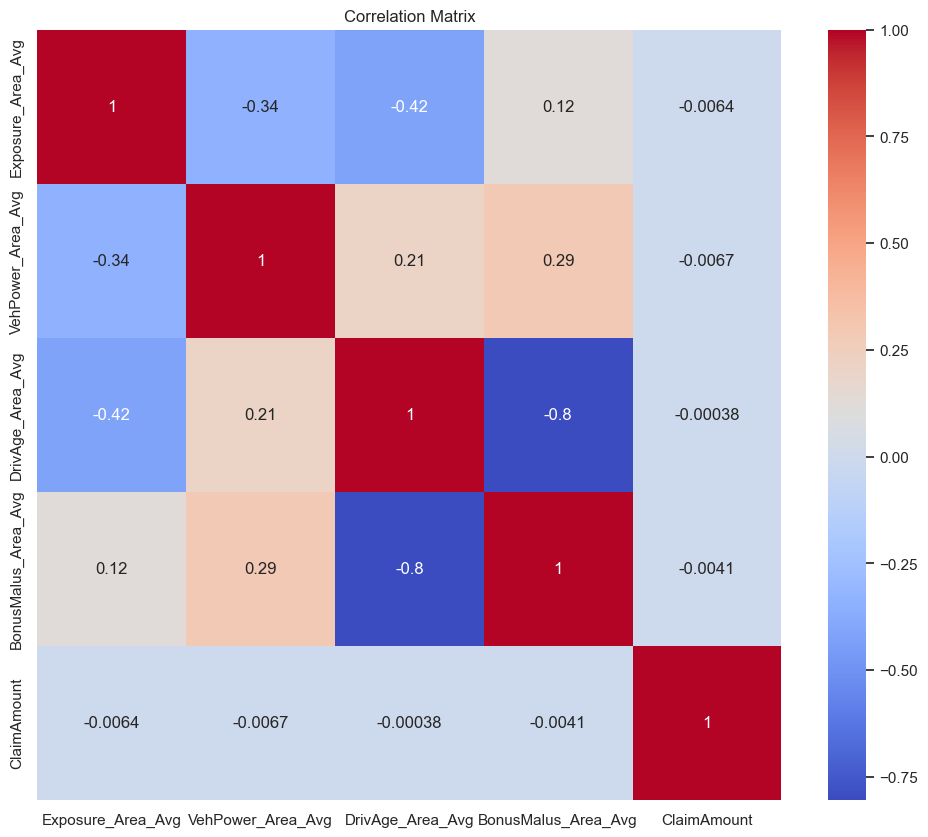

In [391]:
#get all columns that end with _Region_Avg and ClaimAmount
columns_to_keep = [col for col in df_merged.columns if col.endswith('_Area_Avg')] + ['ClaimAmount']
#show correlation matrix
correlation_matrix = df_merged[columns_to_keep].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

Multicollinearity between Bonus Malus and Drive Age?
we do not need area statistics probably.

In [392]:
#convert area to categorical
df_merged['Area'] = df_merged['Area'].astype('category')

#### Veh Power

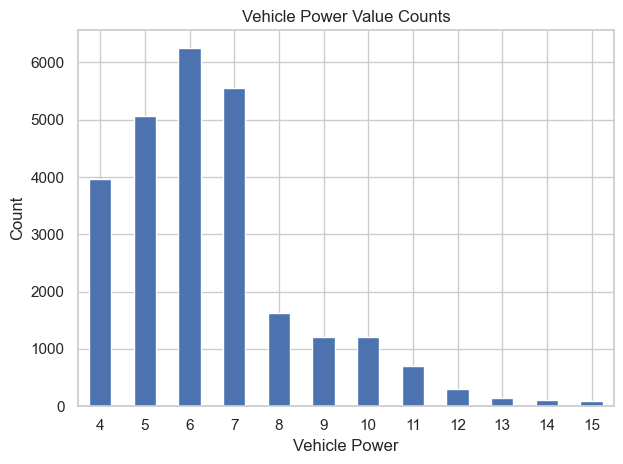

In [393]:
#plot value counts for each vehicle power
#convert to integer for plotting purposes
#make plot pretty
df_merged['VehPower'] = df_merged['VehPower'].astype(int)
df_merged['VehPower'].value_counts().sort_index().plot(kind='bar')
plt.title('Vehicle Power Value Counts')
plt.xlabel('Vehicle Power')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Very imbalanced representation, can create bins for the very powerful, medium power and low power bins and try with both of them for modeling.

In [394]:
# Binning VehPower into 3 categories
bins = [0, 5, 10, 15]
labels = [1, 2, 3]
#where one is lower power, 2 is medium power and 3 is high power
df_merged['VehPower_Binned'] = pd.cut(df_merged['VehPower'], bins=bins, labels=labels)

#convert to categorical
df_merged['VehPower_Binned'] = df_merged['VehPower_Binned'].astype('category')
df_merged['VehPower'] = df_merged['VehPower'].astype('category')

### Numeric Features

In [395]:
#convert IDpol to int32 and convert VehGas into a binary variable 
df_merged['IDpol'] = df_merged['IDpol'].astype(np.int32)


VehAge, DrivAge, BonusMalus, Density

####    Exposure

Exposure The exposure period

In [396]:
df_merged['Exposure'].describe()

count    26209.000000
mean         0.691141
std          0.313415
min          0.002740
25%          0.440000
50%          0.760000
75%          1.000000
max          2.000000
Name: Exposure, dtype: float64

In [397]:
#get the row where exposure is over 1 and get claim amount
df_merged[df_merged['Exposure'] > 1.5]['ClaimAmount']

10044     72.96
10067    743.45
Name: ClaimAmount, dtype: float64

We observe that for regular fuel type there might be a bit higher claim amount for the regular fuel type, however the difference is not very significant.

Text(0.5, 1.0, 'Exposure Distribution')

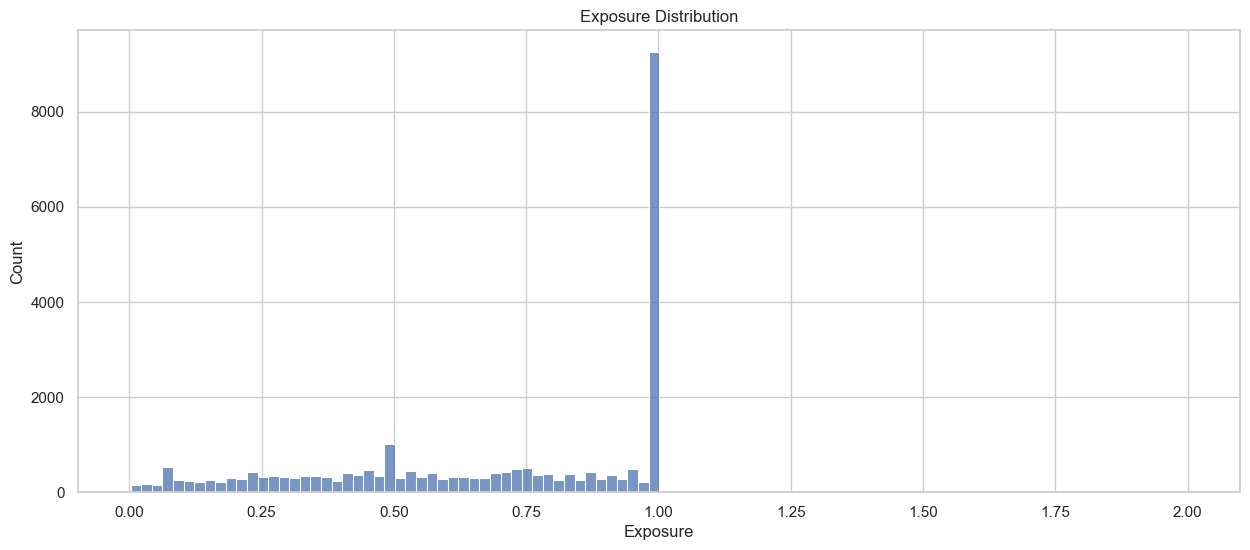

In [398]:
#create a plot of the exposure so it shows all the values even super small ones
plt.figure(figsize=(15, 6))
sns.histplot(df_merged['Exposure'], bins=100)
plt.title('Exposure Distribution')

In [399]:
#what is the correlation between exposure and claim amount
df_merged[['Exposure', 'ClaimAmount']].corr()

,Exposure,ClaimAmount
Exposure,1.000000,-0.026894
ClaimAmount,-0.026894,1.000000


As the distribution and the ranges are okay, and there is small negative almost negligible correlation, we can create new variable which will be frequency of the claim.

In [400]:
#create frequency (per year) of claims
df_merged['ClaimFrequency'] = df_merged['ClaimNb'] / df_merged['Exposure']
df_merged['ClaimFrequency'].describe()

count    26209.000000
mean         3.477434
std         11.120600
min          0.500000
25%          1.000000
50%          1.428571
75%          2.564103
max        365.000000
Name: ClaimFrequency, dtype: float64

#### DrivAge

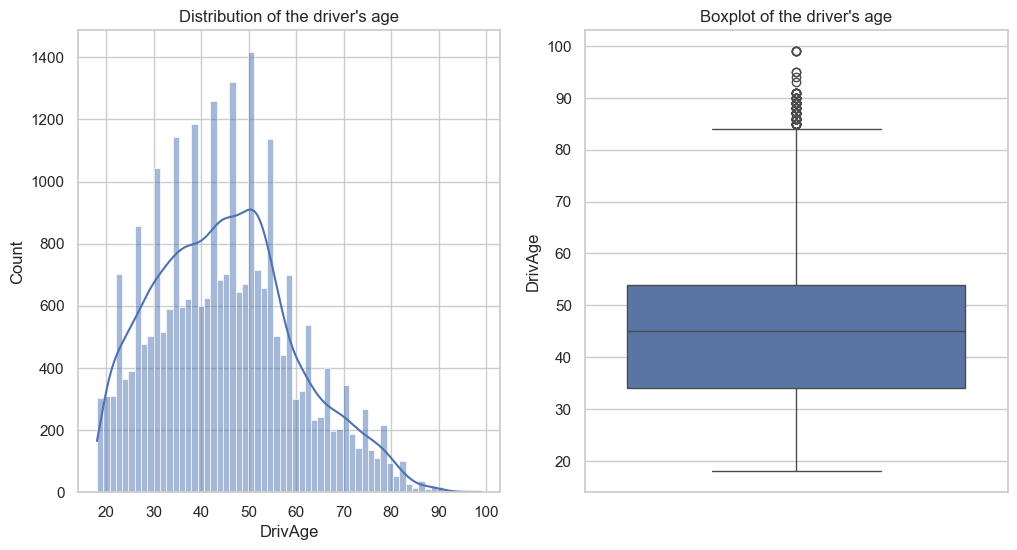

In [401]:
#make 2 figures, one for the distribution of the driver's age and one for the distribution of the driver's age with a boxplot
# #stack them side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_merged['DrivAge'], kde=True)
plt.title('Distribution of the driver\'s age')
plt.subplot(1, 2, 2)
sns.boxplot(y=df_merged['DrivAge'])
plt.title('Boxplot of the driver\'s age')
plt.show()

Wir beobachten, dass die meisten Fahrer im Alter zwischen 30 und 50 Jahren liegen, jedoch gibt es einige Ausreißer, insbesondere Fahrer, die über 80 Jahre alt sind. Um diese Ausreißer effektiv zu behandeln, können wir das Alter in Altersgruppen einteilen. Dieser Ansatz hilft, ähnliche Altersbereiche zusammenzufassen, was die Analyse robuster macht und den Einfluss extremer Werte reduziert.

In [402]:
# Define the bins and corresponding labels
bins = [18, 25, 35, 45, 55, 65, 75, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '66-75', '76-100']

# Create a new column with the binned age groups
df_merged['DrivAge_binned'] = pd.cut(df_merged['DrivAge'], bins=bins, labels=labels, right=False)

# Display the first few rows to see the new binned column
print(df_merged[['DrivAge', 'DrivAge_binned']].head())

   DrivAge DrivAge_binned
0       61          56-65
1       50          46-55
2       36          36-45
3       51          46-55
4       51          46-55


<Axes: xlabel='DrivAge_binned', ylabel='Count'>

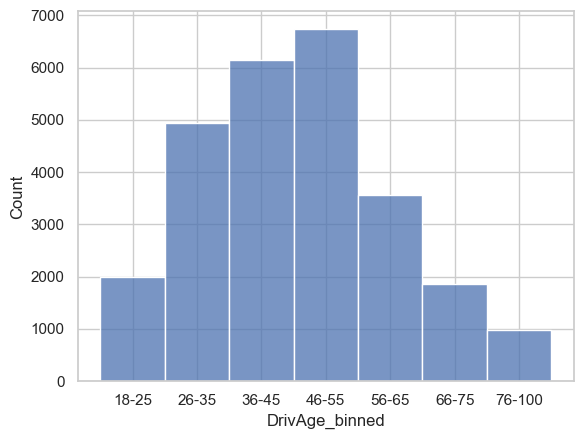

In [403]:
sns.histplot(df_merged['DrivAge_binned'])

	•	Häufigste Altersgruppe: Die häufigste Altersgruppe ist 46-55 Jahre, mit fast 7.000 Fahrern in diesem Bereich. Dies deutet darauf hin, dass Fahrer mittleren Alters in diesem Datensatz am häufigsten vertreten sind.
	•	Symmetrie: Die Verteilung zeigt eine ungefähr symmetrische Form, mit einem allmählichen Anstieg der Häufigkeit von den jüngeren Altersgruppen (18-25, 26-35) zu den mittleren Altersgruppen (46-55), gefolgt von einem allmählichen Rückgang, wenn das Alter über 55 hinausgeht. 
	•	Jüngere Fahrer: Die Altersgruppen 18-25 und 26-35 haben weniger Fahrer im Vergleich zu den mittleren Altersgruppen, wobei die Gruppe 18-25 am wenigsten vertreten ist. 
	•	Ältere Fahrer: Die Anzahl der Fahrer nimmt kontinuierlich ab, wenn das Alter über 55 hinausgeht, wobei die Altersgruppe 76-100 die wenigsten Fahrer umfasst, was darauf hindeutet, dass es in diesem Datensatz deutlich weniger ältere Fahrer gibt.
	•	Gesamtform: Die Verteilung bildet eine glockenähnliche Form, die in den mittleren Altersbereichen ihren Höhepunkt erreicht und an den jüngeren und älteren Extremen abnimmt.


#### Vehicle Age

Vehicle Age variable contains values from 0 to 99 years, which seems to be unrealistic. The data has very obvious left skew, and therefore it should treated.

In [404]:
df_merged['VehAge'].describe()

count    26209.000000
mean         7.343928
std          5.160917
min          0.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         99.000000
Name: VehAge, dtype: float64

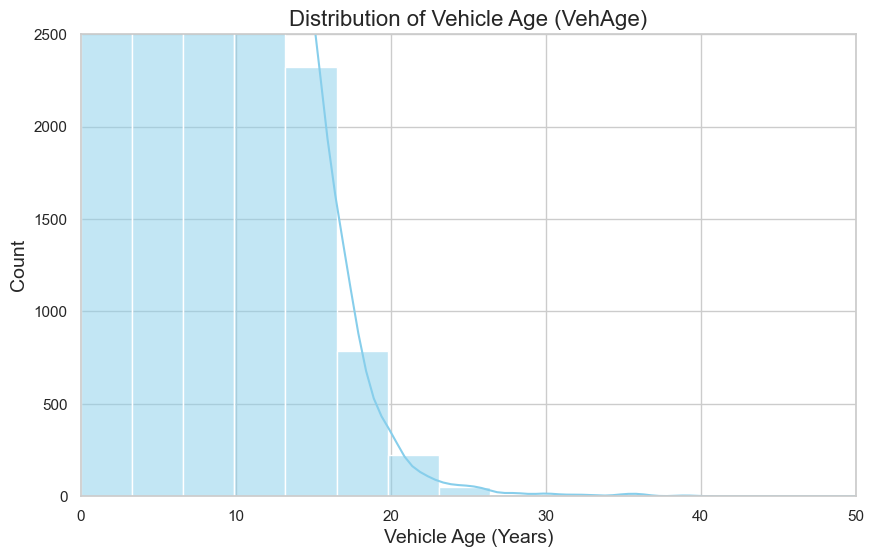

In [405]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot histogram with KDE
sns.histplot(df_merged['VehAge'], bins=30, kde=True, color='skyblue')

# Add titles and labels
plt.title('Distribution of Vehicle Age (VehAge)', fontsize=16)
plt.xlabel('Vehicle Age (Years)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Set limits for better focus
plt.xlim(0, 50)  # Focusing on the age range with data
plt.ylim(0, 2500)  # Adjust as per your data range

# Show the plot
plt.show()

In [406]:
#drop values over 40 years
df_merged = df_merged[df_merged['VehAge'] <= 40]

df_merged[df_merged['VehAge'] > 20]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,...,VehPower_Region_Avg,DrivAge_Region_Avg,BonusMalus_Region_Avg,Exposure_Area_Avg,VehPower_Area_Avg,DrivAge_Area_Avg,BonusMalus_Area_Avg,VehPower_Binned,ClaimFrequency,DrivAge_binned
189,20513,1,1.00,A,4,21,68,50,1,'Regular',...,6.322380,45.329076,65.855163,2438.660085,6.438849,46.483213,62.764388,1,1.000000,66-75
485,31685,1,1.00,C,5,24,20,106,1,'Regular',...,6.384840,44.288630,68.046647,4974.823076,6.461582,45.477092,63.471258,1,1.000000,18-25
582,35243,1,0.50,E,6,22,32,112,3,'Regular',...,6.595238,45.055952,66.009048,4033.277489,6.475916,44.374794,67.519795,2,2.000000,26-35
637,36978,1,0.61,A,9,24,24,95,13,'Diesel',...,6.322380,45.329076,65.855163,2438.660085,6.438849,46.483213,62.764388,2,1.639344,18-25
685,38789,1,1.00,D,7,21,75,112,1,'Regular',...,6.595238,45.055952,66.009048,4311.387497,6.440106,44.509293,66.324223,2,1.000000,76-100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23878,4175240,1,0.72,E,4,21,47,50,1,'Regular',...,6.595238,45.055952,66.009048,4033.277489,6.475916,44.374794,67.519795,1,1.388889,46-55
23971,4177679,1,1.00,C,7,21,71,50,2,'Diesel',...,6.322380,45.329076,65.855163,4974.823076,6.461582,45.477092,63.471258,2,1.000000,66-75
24063,4180332,1,0.22,C,10,31,23,90,14,'Regular',...,6.384840,44.288630,68.046647,4974.823076,6.461582,45.477092,63.471258,2,4.545455,18-25
24108,4181536,1,0.16,E,4,22,32,100,2,'Regular',...,6.595238,45.055952,66.009048,4033.277489,6.475916,44.374794,67.519795,1,6.250000,26-35


<Axes: xlabel='VehAge_binned', ylabel='Count'>

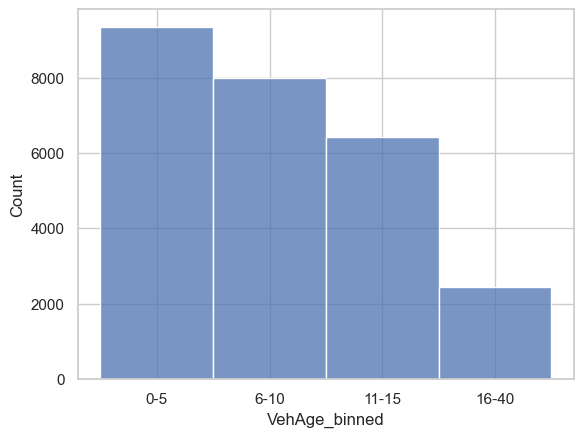

In [407]:
bins = [0, 5, 10, 15, 40]
labels = ['0-5', '6-10', '11-15', '16-40']

df_merged['VehAge_binned'] = pd.cut(df_merged['VehAge'], bins=bins, labels=labels, right=False)


sns.histplot(df_merged['VehAge_binned'])

### BonusMalus and Density


In [155]:
df_merged['BonusMalus'].describe()

count    26441.000000
mean        65.227185
std         20.140856
min         50.000000
25%         50.000000
50%         55.000000
75%         76.000000
max        228.000000
Name: BonusMalus, dtype: float64

<Axes: xlabel='BonusMalus', ylabel='Count'>

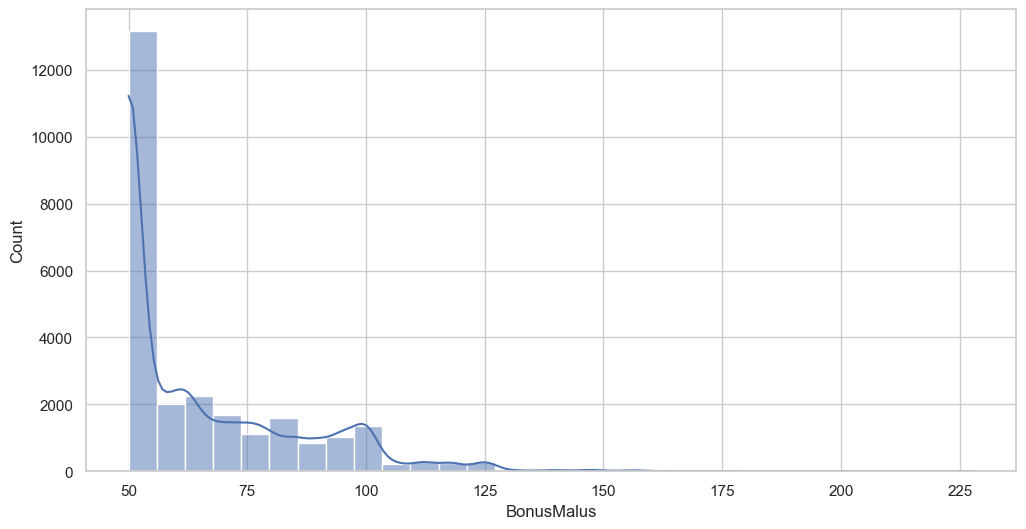

In [410]:
plt.figure(figsize=(12, 6))
#plot frequency barchart
sns.histplot(df_merged['BonusMalus'], bins=30, kde=True)



In [416]:
#how many values with bonus malus are over 150 as a share of the dataset, write the phrase as an f string
f'The percentage of values with BonusMalus over 150 is {df_merged[df_merged["BonusMalus"] > 150].shape[0] / df_merged.shape[0] * 100:.2f}%'


'The percentage of values with BonusMalus over 150 is 0.18%'

In [417]:
#replace all bigger values with 150
df_merged['BonusMalus'] = df_merged['BonusMalus'].apply(lambda x: 150 if x > 150 else x)

#### Density

Let us have a closer look to the distribution of the density.

<Axes: xlabel='Density', ylabel='Count'>

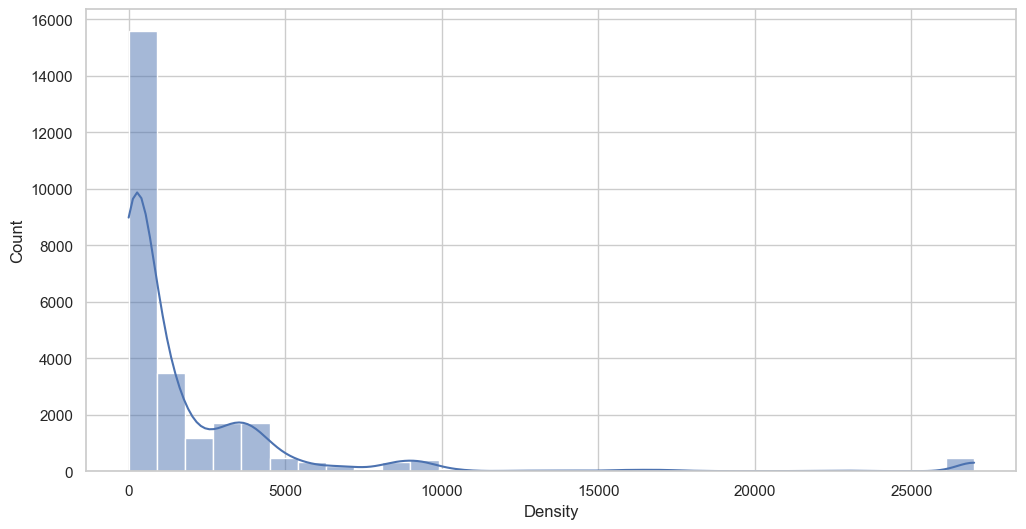

In [419]:
# plot distribution of the density
plt.figure(figsize=(12, 6))
sns.histplot(df_merged['Density'], bins=30, kde=True)


The standard deviation is very high for density, it seems that there are a large amount of different density. So we want to create a new variable which takes log(density).


<Axes: xlabel='Density_log', ylabel='Count'>

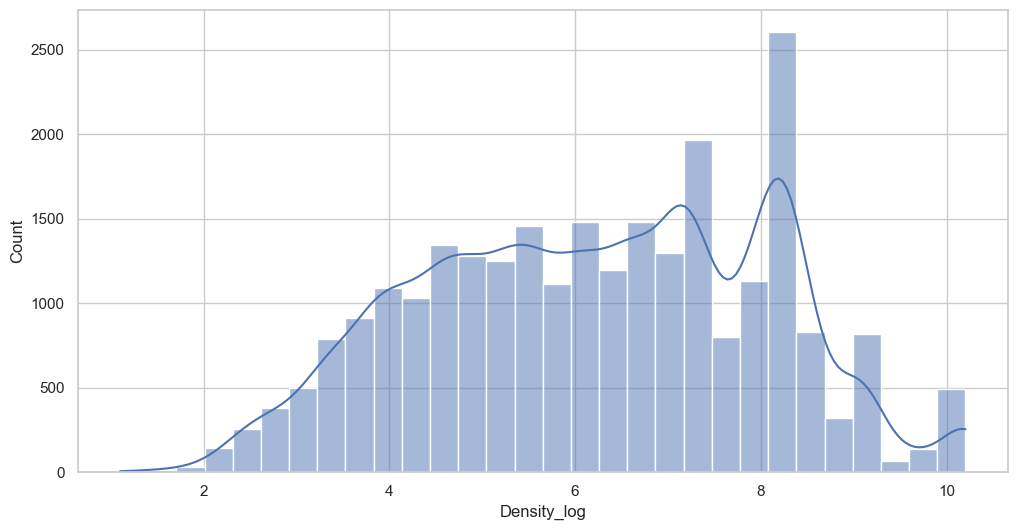

In [421]:
# create a variable for density log
df_merged['Density_log'] = np.log1p(df_merged['Density'])
#plot new variable
plt.figure(figsize=(12, 6))
sns.histplot(df_merged['Density_log'], bins=30, kde=True)


<Axes: >

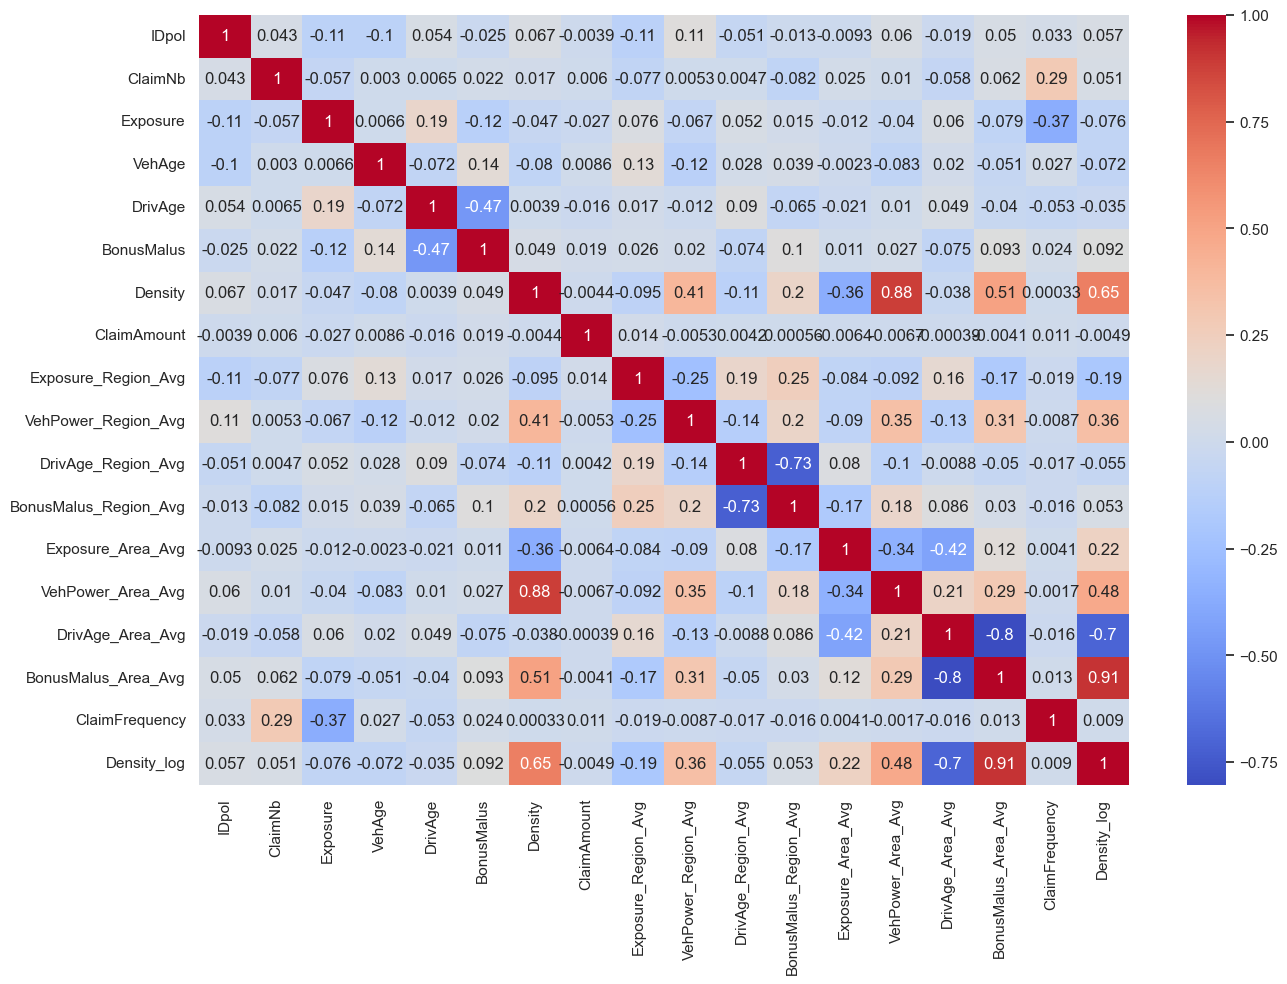

In [425]:
corr_map = df_merged.select_dtypes(include = [np.number]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_map, annot=True, cmap='coolwarm')

Potential Problems:
1. BonusMalus and Age, how is it being assigned? Multicollinearity between them might be a problem
2. Is there different insurance 